# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

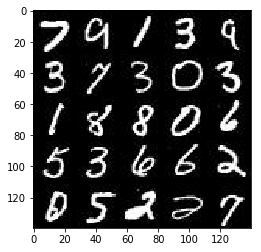

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

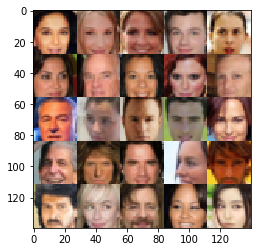

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), 'z_input')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_input, z_input, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    dropout_rate = 0.25
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_layer1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding='same')
        conv_layer1 = tf.layers.dropout(inputs = conv_layer1, rate = dropout_rate)
        conv_layer1 = tf.maximum(alpha * conv_layer1, conv_layer1)
        
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, 5, strides=2, padding='same')
        conv_layer2 = tf.layers.dropout(inputs = conv_layer2, rate = dropout_rate)
        conv_layer2 = tf.layers.batch_normalization(conv_layer2)
        conv_layer2 = tf.maximum(alpha * conv_layer2, conv_layer2)
        
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, 5, strides=2, padding='same')
        conv_layer3 = tf.layers.dropout(inputs = conv_layer3, rate = dropout_rate)
        conv_layer3 = tf.layers.batch_normalization(conv_layer3)
        conv_layer3 = tf.maximum(alpha * conv_layer3, conv_layer3)
        
        flat = tf.reshape(conv_layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse = (not is_train)):

        fc_layer1 = tf.layers.dense(z, 7*7*64)
        fc_layer1 = tf.reshape(fc_layer1, (-1, 7, 7, 64))
        fc_layer1 = tf.layers.batch_normalization(fc_layer1, training = is_train)
        fc_layer1 = tf.maximum(alpha * fc_layer1, fc_layer1)

        
        conv_layer2 = tf.layers.conv2d_transpose(fc_layer1, 128, 5, strides = 2, padding='same')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training = is_train)
        conv_layer2 = tf.maximum(alpha * conv_layer2, conv_layer2)
        
        conv_layer3 = tf.layers.conv2d_transpose(conv_layer2, 256, 5, strides = 1, padding = 'same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training = is_train)
        conv_layer3 = tf.maximum(alpha * conv_layer3, conv_layer3)
         
        conv_layer4 = tf.layers.conv2d_transpose(conv_layer3, 64, 5, strides = 2, padding = 'same')
        conv_layer4 = tf.layers.batch_normalization(conv_layer4, training=is_train)
        conv_layer4 = tf.maximum(alpha * conv_layer4, conv_layer4)

        logits = tf.layers.conv2d_transpose(conv_layer4, out_channel_dim, 5, strides=1, padding='same')

        
        out = tf.tanh(logits)
        
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.multiply(tf.ones_like(d_model_real), smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                
                # noise batch
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # normalize batch_images to -1 <-> 1
                batch_images = batch_images * 2
                
                _ = sess.run(d_optimizer, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # every 10 batches print loss
                if batch_count % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                
                # every 100 batches show image
                if batch_count % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                batch_count += 1
                
        show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.4179


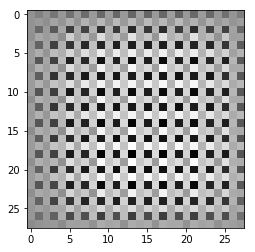

Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.7970
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7757


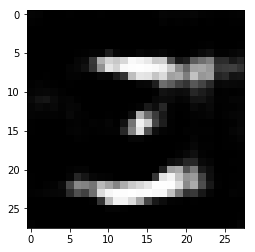

Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7903


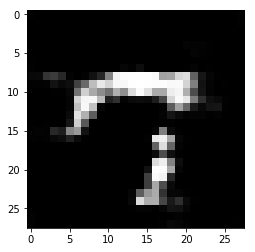

Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.7805


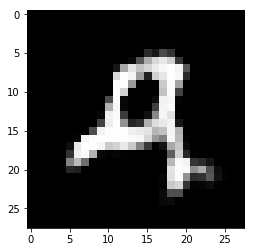

Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.7935


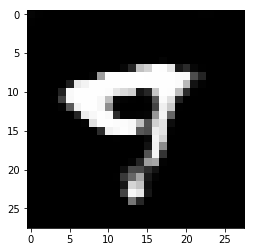

Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.7925


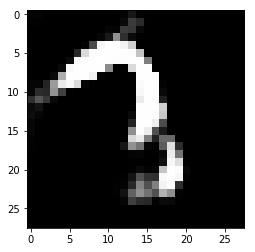

Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7868


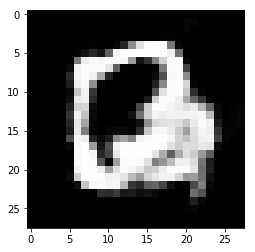

Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7888


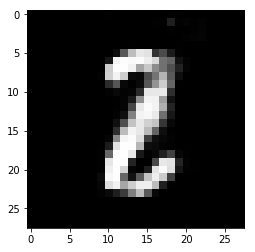

Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.7900
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7873


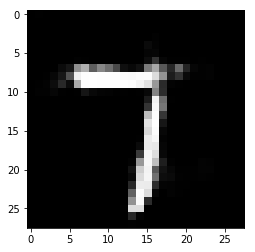

Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7933


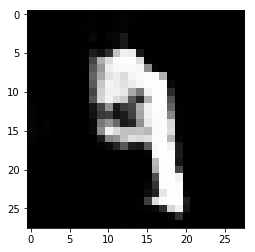

Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7795
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.7890


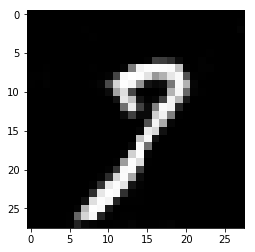

In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6109


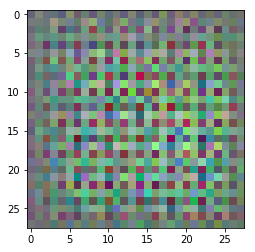

Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7987


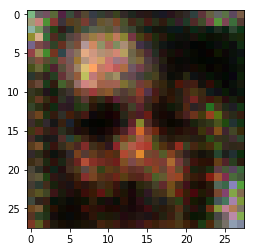

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7631


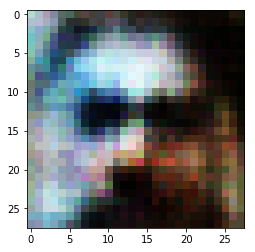

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7744


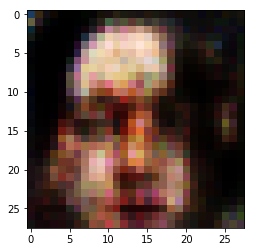

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7984


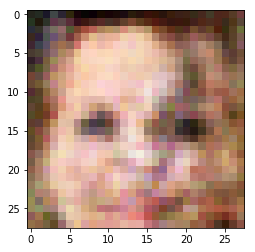

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7908


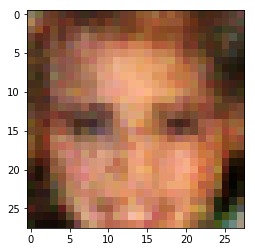

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8035


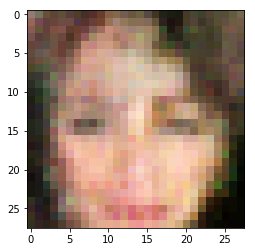

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7921


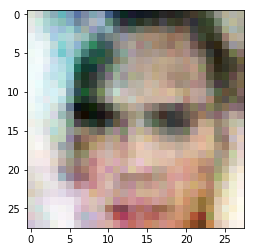

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7908


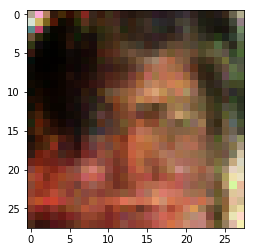

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7882


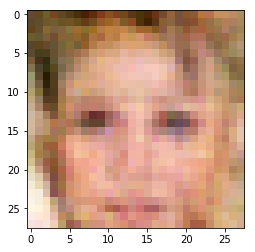

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7897


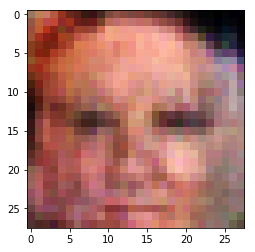

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7899


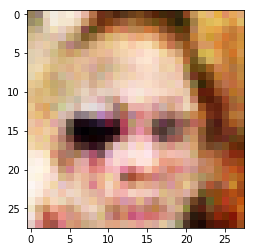

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7931


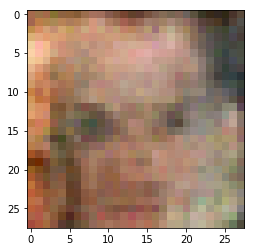

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7972


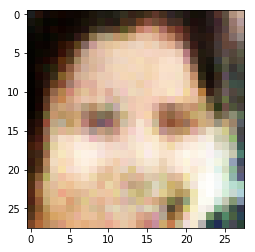

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7941


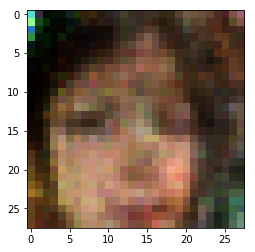

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7945


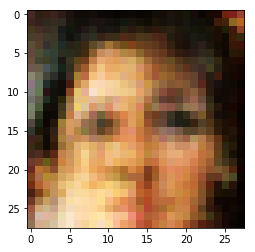

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7950


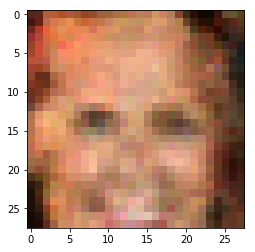

In [16]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.